## 非线性 SVM 例子
---

本节讲述如何使用 tensorflow 在 iris 数据集上实现高斯内核。

高斯内核：

$$K(x_1, x_2) = \exp \left(-\gamma * (x_1 - x_2)^2 \right)$$

In [1]:
# load necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn import datasets
from tensorflow.python.framework import ops
ops.reset_default_graph()

In [2]:
# Create a graph session
sess = tf.Session()

### 加载 iris 数据

我们的 x 值将是 (x1, x2)，其中 x1 = 'Sepal Length'，x2 = 'Petal Width'。

目标值将是花的种类是否是 Setosa。

In [3]:
# Load the data
# iris.data = [(Sepal Length, Sepal Width, Petal Length, Petal Width)]
iris = datasets.load_iris()
x_vals = np.array([[x[0], x[3]] for x in iris.data])
y_vals = np.array([1 if y==0 else -1 for y in iris.target])
class1_x = [x[0] for i,x in enumerate(x_vals) if y_vals[i]==1]
class1_y = [x[1] for i,x in enumerate(x_vals) if y_vals[i]==1]
class2_x = [x[0] for i,x in enumerate(x_vals) if y_vals[i]==-1]
class2_y = [x[1] for i,x in enumerate(x_vals) if y_vals[i]==-1]

### 模型参数

In [4]:
# Declare batch size
batch_size = 150

# Initialize placeholders
x_data = tf.placeholder(shape=[None, 2], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)
prediction_grid = tf.placeholder(shape=[None, 2], dtype=tf.float32)

# Create variables for svm
b = tf.Variable(tf.random_normal(shape=[1,batch_size]))

### 高斯（RBF）内核

我们创建高斯内核用来转换数据点集到高维空间。

两点内核，$x$ 和 $x'$ 如下：

$$K(x, x') = \exp \left(-\gamma \|x - x'\|^2 \right)$$

$\gamma$ 越小，内核越宽，反之亦然。这意味着大的 $\gamma$ 导致高偏差低方差的模型。

如果我们有一个点集向量，大小为 $x$ （批大小为 2），然后我们的公式变成：

$$K(x) = \exp(-\gamma \boldsymbol{x} \cdot \boldsymbol{x}^T)$$

In [5]:
# Gaussian (RBF) kernel
gamma = tf.constant(-50.0)
sq_vec = tf.multiply(2., tf.matmul(x_data, tf.transpose(x_data)))
my_kernel = tf.exp(tf.multiply(gamma, tf.abs(sq_vec)))

### 计算高斯模型

这里，SVM 的损失函数有两个要素，第一个要素是矩阵 $b$ 的求和，第二个要素是 $$\sum \left(K \cdot \|\boldsymbol{b}\|^2 \|\boldsymbol{y}\|^2 \right)$$

我们最终告诉 tensorflow 通过最小化这个负值来最大化损失（以下是这个双要素问题的可怕的缩写版本）$$-\left(\sum \boldsymbol{b} - \sum\left(K \cdot \|\boldsymbol{b}\|^2 \|\boldsymbol{y}\|^2 \right) \right)$$

In [6]:
# Compute SVM model
first_term = tf.reduce_sum(b)
b_vec_cross = tf.matmul(tf.transpose(b), b)
y_target_cross = tf.matmul(y_target, tf.transpose(y_target))
second_term = tf.reduce_sum(tf.multiply(my_kernel, tf.multiply(b_vec_cross, y_target_cross)))
loss = tf.negative(tf.subtract(first_term, second_term))

### 定义预测内核

对预测点我们做和上面完全一样的事情。

In [7]:
# Gaussian (RBF) prediction kernel
rA = tf.reshape(tf.reduce_sum(tf.square(x_data), 1), [-1, 1])
rB = tf.reshape(tf.reduce_sum(tf.square(prediction_grid), 1), [-1, 1])
pred_sq_dist = tf.add(tf.subtract(rA, tf.multiply(2., tf.matmul(x_data, tf.transpose(prediction_grid)))), tf.transpose(rB))
pred_kernel = tf.exp(tf.multiply(gamma, tf.abs(pred_sq_dist)))

prediction_output = tf.matmul(tf.multiply(tf.transpose(y_target), b), pred_kernel)
prediction = tf.sign(prediction_output - tf.reduce_mean(prediction_output))
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(prediction), tf.squeeze(y_target)), tf.float32))

*注：tf.squeeze() 函数，从tensor中删除所有大小是1的维度*

### 优化函数

我们声明梯度递减优化器并初始化我们的模型变量（b）

In [8]:
# Declare optimizer
my_opt = tf.train.GradientDescentOptimizer(0.01)
train_step = my_opt.minimize(loss)

# Initialize variables
init = tf.global_variables_initializer()
sess.run(init)

### 运行分类

我们迭代训练 300 次。每隔 75 次打印损失。

In [9]:
# Training loop
loss_vec = []
batch_accuracy = []
for i in range(300):
    rand_index = np.random.choice(len(x_vals), size=batch_size)
    rand_x = x_vals[rand_index]
    rand_y = np.transpose([y_vals[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    
    temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vec.append(temp_loss)
    acc_temp = sess.run(accuracy, feed_dict={x_data: rand_x, y_target: rand_y, prediction_grid: rand_x})
    batch_accuracy.append(acc_temp)
    
    if (i+1) % 75 == 0:
        print('Step #' + str(i))
        print('Loss = ' + str(temp_loss))

Step #74
Loss = -126.914
Step #149
Loss = -239.414
Step #224
Loss = -351.914
Step #299
Loss = -464.414


### 绘制结果

我们现在创建网格来绘制 SVM 分类线。

In [11]:
# Createa a mesh to plot points in
x_min, x_max = x_vals[:, 0].min() - 1, x_vals[:, 0].max() + 1
y_min, y_max = x_vals[:, 1].min() - 1, x_vals[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                    np.arange(y_min, y_max, 0.02))

grid_points = np.c_[xx.ravel(), yy.ravel()]
[grid_predictions] = sess.run(prediction, feed_dict={x_data: rand_x,
                                                     y_target: rand_y,
                                                     prediction_grid: grid_points})
grid_predictions = grid_predictions.reshape(xx.shape)

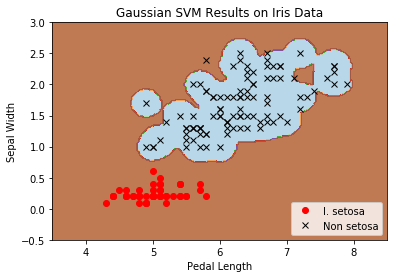

In [12]:
%matplotlib inline
# Plot points and grid
plt.contourf(xx, yy, grid_predictions, cmap=plt.cm.Paired, alpha=0.8)
plt.plot(class1_x, class1_y, 'ro', label='I. setosa')
plt.plot(class2_x, class2_y, 'kx', label='Non setosa')
plt.title('Gaussian SVM Results on Iris Data')
plt.xlabel('Pedal Length')
plt.ylabel('Sepal Width')
plt.legend(loc='lower right')
plt.ylim([-0.5, 3.0])
plt.xlim([3.5, 8.5])
plt.show()

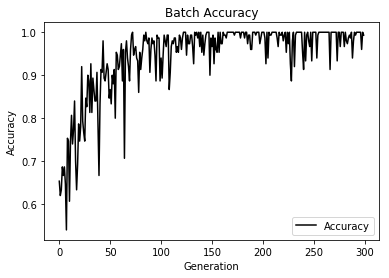

In [13]:
# Plot batch accuracy
plt.plot(batch_accuracy, 'k-', label='Accuracy')
plt.title('Batch Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

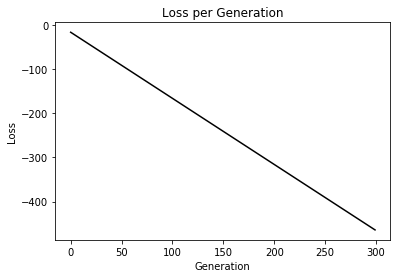

In [14]:
# Plot loss over time
plt.plot(loss_vec, 'k-')
plt.title('Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()